# **1. Data Engineering**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind 
import re

import matplotlib.cm as cm
import matplotlib.colors as mcolors


from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.impute import SimpleImputer
from numpy import isnan

import networkx as nx
import json
from pgmpy.base import DAG

from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore, BDsScore


from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.metrics import correlation_score, structure_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score,confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve



In [5]:
# load the cleaned up data ready for feature engineering.
icc_clean= pd.read_csv("/kaggle/input/processed-data/cleaned_icc_data.csv")
# Prepare DataFrame
icc_features = pd.DataFrame()
icc_features['ID'] = icc_clean['RESPNR']

In [6]:
icc_features.shape

(564, 1)

## **Corticosteroid-free clinical and biochemical remission at 52 weeks**

In [7]:
# remap values in general wellbeing 'W4_HB_SSCAI_WB' as so
# 0: Very well – 7-10
# 1: Slightly below par – 6
# 2: Poor – 5 
# 3: Very poor – 4
# 4: Terrible – 0-3

# Step 1: Remap the general wellbeing values 
#----------------------------------------------------------
remap_dict = {
    11: 0,     10: 0,     9: 0,     8: 0,     7: 0,
    6: 1,
    5: 2,
    4: 3,
    3: 4,    2: 4,    1: 4,    0: 4
}

# Map the values of 'W4_HB_SSCAI_WB' to the new 'W4_HB_SSCAI_WB_remapped'
icc_clean['W4_HB_SSCAI_WB_remapped'] = icc_clean['W4_HB_SSCAI_WB'].map(remap_dict)

# Step 2: Calculate the HBI at 52 weeks (sum of relevant columns)
#----------------------------------------------------------
hbi_cols = ['W4_HB_SSCAI_WB_remapped', 'W4_HB_PAIN', 'W4_HB_STOOL', 'W4_HB_JOINT', 'W4_HB_EYE', 
            'W4_HBI_MOUTH', 'W4_HB_EN', 'W4_HB_PG', 'W4_HB_ANALFIS', 'W4_HB_PERIANFIS', 'W4_HB_PERIANAB']

# Calculate the HBI sum (NaN if all values are missing)
icc_features['HBI_52w'] = np.where(icc_clean[hbi_cols].isnull().all(axis=1),
                                   np.nan,
                                   icc_clean[hbi_cols].sum(axis=1, skipna=True))

# Step 3: Identify patients with missing values and count nulls for each patient in the HBI columns
#----------------------------------------------------------
hbi_null = pd.DataFrame()
hbi_null['ID'] = icc_clean['RESPNR']
hbi_null['Null_Count'] = icc_clean[hbi_cols].isnull().sum(axis=1)

# Step 4: if not whole row is not null or completely null.
#----------------------------------------------------------
null_patients = []
for index, row in hbi_null.iterrows():
    if row['Null_Count'] != 0 and row['Null_Count'] != 11:
        null_patients.append(row['ID'])
        #print(row['ID'], row['Null_Count'])

# patients with error margin more than 1 HBI unreliable and thus changed to NULL: 4640 10580 13200 17440 13860
error_patients = [4640, 10580, 13200, 17440, 13860]
for ID in error_patients:
    icc_features.loc[icc_features['ID'] == ID, 'HBI_52w'] = np.nan

# Step 6: HBI categories
# hbi 52w groups
bins = [0, 5, 7, 16, np.inf]
labels = [1, 2, 3, 4]

icc_features['HBIGroup_52w'] = pd.cut(icc_features['HBI_52w'], bins=bins, labels=labels, right=False)
icc_features.loc[icc_features['HBI_52w'].isnull(), 'HBIGroup_52w'] = np.nan
# Step 7: Corticosteroid use at 52 weeks
#----------------------------------------------------------
icc_features['Steroid_52w'] = icc_clean['W4_CORT_BIN']


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


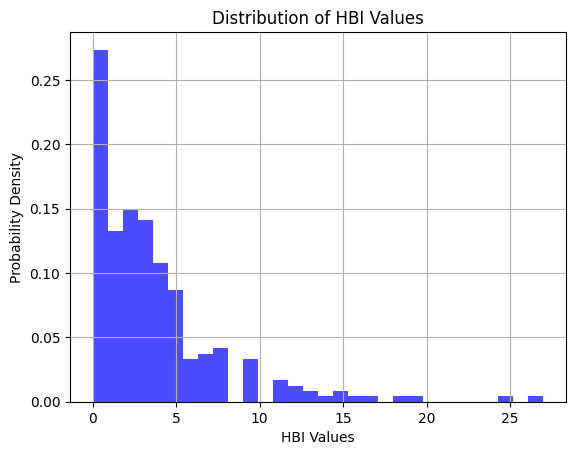

In [8]:
hbi_values = icc_features['HBI_52w']

plt.hist(hbi_values, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Distribution of HBI Values')
plt.xlabel('HBI Values')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [9]:
hbi_values.isnull().sum()

296

## **Outcome Variable: Remission**

In [10]:
# Step 8: Define remission based on HBI and corticosteroid use
#----------------------------------------------------------
# normal CRP (<10)
# W4_LAB_CRP
#icc_features['NormalCRP_52w'] = np.where(icc_clean['W4_LAB_CRP'].isnull(), np.nan, (icc_clean['W4_LAB_CRP'] < 100).astype(int))

# normal calpro (<100)
# W4_LAB_CAL
#icc_features['NormalCalpro_52w'] = np.where(icc_clean['W4_LAB_CAL'].isnull(), np.nan, (icc_clean['W4_LAB_CAL'] < 100).astype(int))

# combine HBI and cortocosteroid use to indicate whether patient is in remission or not
# cant use crp and calpro because too many missing values
conditions = (icc_features[['HBI_52w', 'Steroid_52w']].isnull()).any(axis=1)
icc_features['Remission_52w'] = np.where(conditions, np.nan, 
                                         ((icc_features['HBI_52w'] < 5) & (icc_features['Steroid_52w'] == 0))).astype(float)

# Step 9: Patients in remission while on corticosteroids
#----------------------------------------------------------
# also make column indicating the patients that use corticosteroid and are in remission
icc_features['Remission_steroid_52w'] = np.where(conditions, np.nan, 
                                         ((icc_features['HBI_52w'] < 5) & (icc_features['Steroid_52w'] == 1))).astype(float)



# Step 10: Update Remission_52w based on reasons for stopping treatment
#----------------------------------------------------------
# take WS_SREASON (reason why medication was stopped) for those patients who have HBI_52w = null. if the reason indicates,
# mark these patients as Remission_52w = 0 instead of null.

# WS_SREASON mappings
# 1: initiative patient themselves
# 2: no response
# 3: loss of response
# 4: side effects
# 5: unknown
# 6: pregnancy
# 7: stable remission
# 8: malignancy
# 9: other


# (WS_SREASON indicates why the treatment stopped)
for index, row in icc_clean.iterrows():
    if row['WS_SREASON'] == 2 or row['WS_SREASON'] == 3 or row['WS_SREASON'] == 4 or row['WS_SREASON'] == 8:
        icc_features.loc[index, 'Remission_52w'] = 0  # Not in remission due to failure
    if row['WS_SREASON'] == 7 and icc_features.loc[index, 'Steroid_52w'] == 0:
        icc_features.loc[index, 'Remission_52w'] = 1  # Stable remission, off steroids
    if row['WS_SREASON'] == 7 and icc_features.loc[index, 'Steroid_52w'] == 1:
        icc_features.loc[index, 'Remission_steroid_52w'] = 1  # Stable remission, on steroids



# Step 12: Print the counts for the remission outcomes
#----------------------------------------------------------
print(icc_features.Remission_52w.value_counts())
print(icc_features.Remission_steroid_52w.value_counts())

# Additional: Display null counts for HBI and the number of error patients
#print(f"Patients with errors in HBI: {null_patients}")
print(f"Null value counts for HBI at 52 weeks: {icc_features['HBI_52w'].isnull().sum()}")



Remission_52w
0.0    283
1.0    164
Name: count, dtype: int64
Remission_steroid_52w
0.0    256
1.0     12
Name: count, dtype: int64
Null value counts for HBI at 52 weeks: 296


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [11]:
print(icc_features.Remission_52w.value_counts())
icc_features.shape

Remission_52w
0.0    283
1.0    164
Name: count, dtype: int64


(564, 6)

### **Medicine**

In [12]:
# Create the contingency table
pd.crosstab(icc_features['Remission_52w'], icc_clean['MEDICINE'])

MEDICINE,180,202
Remission_52w,,
0.0,130,153
1.0,52,112


In [13]:
# General utility function for mapping medicines
def map_medicine(row, medicine_mapping):
    """ Map medicine codes to category values. """
    return medicine_mapping.get(row['MEDICINE'], None)

# Medicine Mapping
medicine_mapping = {180: 1, 290: 1, 202: 2}

# Map Medicine
icc_features['Medicine'] = icc_clean.apply(map_medicine, axis=1, medicine_mapping=medicine_mapping)


## **Age at diagnosis and at inclusion**

In [14]:
def calculate_age_at_diagnosis(diagnosis_date, birth_year):
    """ Calculate age at diagnosis. """
    diagnosis_date = pd.to_datetime(diagnosis_date)
    return diagnosis_date.year - birth_year if pd.notnull(diagnosis_date) and pd.notnull(birth_year) else np.nan

def calculate_age_at_inclusion(inclusion_date, birth_year):
    """ Calculate age at inclusion. """
    inclusion_date = pd.to_datetime(inclusion_date)
    return inclusion_date.year - birth_year if pd.notnull(inclusion_date) and pd.notnull(birth_year) else np.nan

def categorize_age(age_series, bins, labels):
    """ Categorize individuals into age groups. """
    return pd.cut(age_series, bins=bins, labels=labels, right=False)

# Age Calculation
icc_features['AgeDiagnosis'] = icc_clean.apply(lambda row: calculate_age_at_diagnosis(row['D_DATE'], row['BIRTHYEAR']), axis=1)
icc_features['AgeInclusion'] = icc_clean.apply(lambda row: calculate_age_at_inclusion(row['W1_PLANVISDAT'], row['BIRTHYEAR']), axis=1)
# Age Group Categorization
# categorise in age ranges: <16 (1), 16-24 (2), 25-60 (3), >60 (4)
bins = [0, 16, 24, 60, np.inf]
labels = [1, 2, 3, 4]

icc_features['AgeDiagnosisGroup'] = categorize_age(icc_features['AgeDiagnosis'], bins,labels)
icc_features['AgeInclusionGroup'] = categorize_age(icc_features['AgeInclusion'], bins, labels)

## **Disease duration**

In [15]:
# disease duration from diagnosis til inclusion. In years.
# diagnosis: D_DATE
# inclusion: W1_PLANVISDAT

def calculate_duration(start_date, end_date):
    """ Calculate disease duration in years. """
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    return end_date.year - start_date.year if pd.notnull(start_date) and pd.notnull(end_date) else np.nan

# Duration Calculation
icc_features['Duration'] = icc_clean.apply(lambda row: calculate_duration(row['D_DATE'], row['W1_PLANVISDAT']), axis=1)

# Duration Group Categorization: 
duration_bins = [0, 6,11, 20, np.inf]
duration_labels = [1, 2, 3,4]
icc_features['DurationGroup'] = categorize_age(icc_features['Duration'], duration_bins, duration_labels)


## **BMI**

In [16]:
# BMI (length and weigth): <18.5, 18.5-24.9, 25.0-29.9, >30.0
# calculate using: W1_HEIGHT, W1_WEIGHT

def calculate_bmi(height, weight):
    """ Calculate BMI from height and weight. """
    return weight / ((height / 100) ** 2)
    
def categorize_bmi(bmi_series, bins, labels):
    """ Categorize BMI into predefined groups. """
    return pd.cut(bmi_series, bins=bins, labels=labels, right=False)

# BMI Calculation and Categorization: <18.5 (1), 18.5-24.9 (2), 25.0-29.9 (3), >30.0 (4)

icc_features['BMI'] = icc_clean.apply(lambda row: calculate_bmi(row['W1_HEIGHT'], row['W1_WEIGHT']), axis=1)
bmi_bins = [0,  21.393, 23.519,  25.922, np.inf]
bmi_labels = [1, 2, 3, 4]
icc_features['BMIGroup'] = categorize_bmi(icc_features['BMI'], bmi_bins, bmi_labels)


## **Smoking, Gender, Disease Location, and Behavior**

In [17]:
# at diagnosis: D_MON_LOC_CD
# at inclusion: W1_MON_LOC_CD_INC
# ileum (1) = 1, 4; colon (2) = 2, 6; both (3) = 3, 5

def map_location(row, col, location_mapping):
    """ Map disease location codes to categories. """
    return location_mapping.get(row[col], None)

# Location Mapping
location_mapping = {1: 1, 4: 1, 2: 2, 6: 2, 3: 3, 5: 3}

# Smoking, Gender, Disease Location, and Behavior
icc_features['Smoking'] = icc_clean['W1_SMOK']# at inclusion W1_SMOK 1: never, 2: past, 3: current
icc_features['Gender'] = icc_clean['SEX']#  1 = male, 2 = female
icc_features['LocationDiagnosis'] = icc_clean.apply(map_location, axis=1, col='D_MON_LOC_CD', location_mapping=location_mapping)
icc_features['LocationInclusion'] = icc_clean.apply(map_location, axis=1, col='W1_MON_LOC_CD_INC', location_mapping=location_mapping)

# at diagnosis: D_MON_BEH_CD
# at inclusion: W1_MON_BEH_CD_INC
# inflammatory (1) = 1; stricturing (2) = 2; penetrating (3) = 3
icc_features['BehaviorDiagnosis'] = icc_clean['D_MON_BEH_CD']
icc_features['BehaviorInclusion'] = icc_clean['W1_MON_BEH_CD_INC']

## **Calpro**

In [18]:
# icc_clean W1_LAB_CAL
icc_features['Calpro'] = icc_clean['W1_LAB_CAL']

# Calpro Group Categorization
calpro_bins = [0,  100, 250, np.inf]
calpro_labels = [1, 2, 3]
icc_features['CalproGroup'] = pd.cut(icc_features['Calpro'], bins=calpro_bins, labels=calpro_labels, right=False)
icc_features.loc[icc_features['Calpro'].isnull(), 'CalproGroup'] = np.nan

## **CRP**

In [19]:
# --> W1_LAB_CRP
icc_features['CRP'] = icc_clean['W1_LAB_CRP']

# CRP Group Categorization: CRP: <10 (1), >10 (2)
crp_bins = [0, 5,np.inf]
crp_labels = [1, 2]
icc_features['CRPGroup'] = pd.cut(icc_features['CRP'], bins=crp_bins, labels=crp_labels, right=False)
icc_features.loc[icc_features['CRP'].isnull(), 'CRPGroup'] = np.nan

## **Thrombocytes**

In [20]:
# icc_clean W1_LAB_TB

icc_features['Thrombocytes'] = icc_clean['W1_LAB_TB']

# Thrombocytes Group Categorization
thrombocytes_bins = [0, 247.5,294,  336.5,  457 , np.inf]
thrombocytes_labels = [1, 2,3,4,5]
icc_features['ThrombocytesGroup'] = pd.cut(icc_features['Thrombocytes'], bins=thrombocytes_bins, labels=thrombocytes_labels, right=False)
icc_features.loc[icc_features['Thrombocytes'].isnull(), 'ThrombocytesGroup'] = np.nan

## **Apendectomy**

In [21]:
# apendectomy in the medical history of patient: no (0), yes (1)
# --> MH_AP_UC

icc_features['Apendectomy'] = icc_clean['MH_AP_UC']

## **Medical history**

In [22]:
# medical history: cancer yes (1), cancer no (0)
# --> Ever cancer: CM_C_CRC, CM_C_L, CM_C_BR, CM_C_NHL, CM_C_NMSC, CM_C_MSC, CM_C_P, CM_C_CX, CM_C_O

conditions = [
    icc_clean[['CM_C_CRC', 'CM_C_L', 'CM_C_BR', 'CM_C_NHL', 'CM_C_NMSC', 'CM_C_MSC', 'CM_C_P', 'CM_C_CX', 'CM_C_O']].eq(1).any(axis=1),
    icc_clean[['CM_C_CRC', 'CM_C_L', 'CM_C_BR', 'CM_C_NHL', 'CM_C_NMSC', 'CM_C_MSC', 'CM_C_P', 'CM_C_CX', 'CM_C_O']].isnull().all(axis=1)
]
choices = [1, np.nan]
icc_features['CancerEver'] = np.select(conditions, choices, default=0)


## **Prior surgery**

In [23]:

# Combine the surgery columns into a single column indicating any surgery (1) or no surgery (0)
surgery_columns = ['MH_CD_PREV_SUR', 'MH_CD_PERIAN_SUR', 'W1_CO_CD_SUR', 'W1_CO_CD_PERIANSUR']

# Condition 1: If any of the surgery columns is marked as 'yes' (1), prior surgery is present.
prior_surgery_any = icc_clean[surgery_columns].eq(1).any(axis=1)

# Condition 2: If 'MH_CD_PREV_SUR' is 2, meaning previous surgery on colon, assign prior surgery.
prior_surgery_colon = icc_clean['MH_CD_PREV_SUR'].eq(2)

# Condition 3: If 'MH_CD_PREV_SUR' is 3, meaning previous surgery on both colon and small intestine.
prior_surgery_colon_intestine = icc_clean['MH_CD_PREV_SUR'].eq(3)

# Condition 4: If all surgery-related columns are NaN, meaning no surgery info, handle as missing.
no_surgery_info = icc_clean[surgery_columns].isna().all(axis=1)

# Combine all conditions
conditions = [
    prior_surgery_any,                  # Any surgery
    prior_surgery_colon,                 # Surgery on colon
    prior_surgery_colon_intestine,       # Surgery on colon and intestine
    no_surgery_info                      # No surgery info
]

# Define corresponding choices for each condition
choices = [1, 1, 1, np.nan]  # Assign 1 if any surgery is present, else NaN for missing data

# Use np.select to apply conditions and set the 'PriorSurgery' column
icc_features['PriorSurgery'] = np.select(conditions, choices, default=0)

# Check the result to verify
icc_features['PriorSurgery'].value_counts()


PriorSurgery
1.0    335
0.0    228
Name: count, dtype: int64

## **Extraintestinal manifestations (EIM)**

In [24]:
# Create reusable function for conditions
def create_eim_condition(columns, value=1):
    """Return condition for checking if any of the specified columns equals the given value."""
    return icc_clean[columns].eq(value).any(axis=1)

# Create reusable function for null checks
def create_null_condition(columns):
    """Return condition to check if all values in the specified columns are null."""
    return icc_clean[columns].isnull().all(axis=1)

# Binary. Whether any EIM present 1 or not 0, , 'W1_HB_ARTHRITIS' is null
eim_columns =['W1_HB_JOINT', 'W1_HB_EYE', 'W1_HBI_MOUTH', 'W1_HB_EN', 'W1_HB_PG', 'W1_HB_ANALFIS', 
               'W1_HB_PERIANFIS', 'W1_HB_PERIANAB', 'W1_FISTEL_Y_N', 'W1_PERIAN_DRAIN']
eim_columns1 = ['W1_PERIAN_DRAIN']
icc_features['EIM'] = np.select(
    [create_eim_condition(eim_columns, 1),
     create_eim_condition(eim_columns1, 1), 
     create_null_condition(eim_columns)],
    [1,1, np.nan],
    default=0
)


# Conditions for Rheumatic EIM (joint or arthritis)
rheumatic_columns = ['W1_HB_JOINT']#, 'W1_HB_ARTHRITIS']
icc_features['EIMRhe'] = np.select(
    [create_eim_condition(rheumatic_columns, 1), create_null_condition(rheumatic_columns)],
    [1, np.nan],
    default=0
)

# Conditions for Skin EIM (mouth, EN, PG, anal fissure, perianal issues, fistula, drainage)
skin_columns = ['W1_HBI_MOUTH', 'W1_HB_EN', 'W1_HB_PG', 'W1_HB_ANALFIS', 
                'W1_HB_PERIANFIS', 'W1_HB_PERIANAB', 'W1_FISTEL_Y_N',
                'W1_PERIAN_DRAIN']
icc_features['EIMSkin'] = np.select(
    [create_eim_condition(skin_columns, 1), create_null_condition(skin_columns)],
    [1, np.nan],
    default=0
)

# Conditions for Other EIM (eye - uveitis)
icc_features['EIMOther'] = np.select(
    [icc_clean['W1_HB_EYE'].eq(1), icc_clean['W1_HB_EYE'].isnull()],
    [1, np.nan],
    default=0
)

# Classify all EIMs into categories: 0 = none, 1 = rheumatic, 2 = skin, 3 = other, 4 = rhe + skin, 5 = rhe + other, 6 = skin + other, 7 = all
# EIM all in one. categories
# 0: none
# 1: rheumatic
# 2: skin
# 3: other
# 4: rhe + skin
# 5: rhe + other
# 6: skin + other
# 7: all
icc_features['EIMClassified'] = np.select(
    [
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(0) & icc_features['EIMOther'].eq(0)),
        (icc_features['EIMRhe'].eq(0) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(0)),
        (icc_features['EIMRhe'].eq(0) & icc_features['EIMSkin'].eq(0) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(0)),
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(0) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].eq(0) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].isnull() & icc_features['EIMSkin'].isnull() & icc_features['EIMOther'].isnull())
    ],
    [1, 2, 3, 4, 5, 6, 7, np.nan],
    default=0
)

## **Perianal disease**

In [25]:
# perianal disease yes 1, no 0
icc_features['PerianalDisease'] = icc_clean['D_MON_PERIAN_CD']

## **Charlson Comorbidity Index (CCI)**

In [26]:
# number of comorbidities
# --> columns indicating presence of a specific comorbidity
# --> CM_M_DM, CM_M_HCHOL, CM_IN_HIV, CM_IN_HV, CM_NEU_EP, CM_NEU_MIG, CM_NEU_PAR, CM_HEAR, CM_VIS, CM_CV_AH,
# --> CM_CV_CVA, CM_CV_HEARTC, CM_CV_HEARTD, CM_CV_HEARTR, CM_CV_HEARTV, CM_LUNG_ASTMA, CM_LUNG_COPD, CM_SKIN_PS, CM_SKIN_E, 
# --> CM_RI, CM_ALC_LIV, CM_ALC_O, CM_LM_RA, CM_LM_SPA, CM_LM_OP, CM_LM_PA, CM_LM_CB, CM_IM_C, CM_IM_O, CM_PSY_MR, CM_PSY_DEM,
# --> CM_PSY_DR, CM_PSY_ALC, CM_PSY_DEP, CM_PSY_A, CM_PSY_ASS, CM_PSY_ADHD, CM_PSY_B, CM_PSY_P, CM_PSY_BO
# weights calculated based on https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6684052/

# weights:
# Myocardial infarction: 1
# Congestive heart failure: 1
# - CVA 'CM_CV_CVA'
# - coronary heart disease 'CM_CV_HEARTC'
# - heart decompensation 'CM_CV_HEARTD'
# Peripheral vascular disease: 1
# Cerebrovascular disease: 1
# Dementia: 1
# - mental impairment 'CM_PSY_MR'
# - dementia 'CM_PSY_DEM'
# Chronic pulmonary disease: 1
# - asthma 'CM_LUNG_ASTMA'
# - COPD 'CM_LUNG_COPD'
# Rheumatic disease: 1
# - rheumathoid arthritis 'CM_LM_RA'
# Peptic ulcer disease: 1
# Mild liver disease: 1
# - Hepatitis B/C 'CM_IN_HV'
# - chronic alcoholic liver disease 'CM_ALC_LIV'
# - other alcohol realted disease 'CM_ALC_O'
# Diabetes without chronic complications: 1
# - diabetes mellitus 'CM_M_DM'
# Diabetes with chronic complications: 2
# Hemiplegia or paraplegia: 2
# Renal disease: 2
# Moderate or severe liver disease: 3
# - chronic kidney failure 'CM_RI'
# Metastatic solid tumor: 6
# AIDS/HIV: 6
# - HIV 'CM_IN_HIV'


# Define the weights for each comorbidity
weights = {
    'CM_M_DM': 1,
    'CM_IN_HIV': 6, 
    'CM_IN_HV': 1,
    'CM_CV_CVA': 1,
    'CM_CV_HEARTC': 1,
    'CM_CV_HEARTD': 1,
    'CM_CV_HEARTV': 1,
    'CM_LUNG_ASTMA': 1,
    'CM_LUNG_COPD': 1,
    'CM_RI': 3,
    'CM_ALC_LIV': 1,
    'CM_ALC_O': 1,
    'CM_LM_RA': 1,
    'CM_PSY_MR': 1,
    'CM_PSY_DEM': 1,
}

# List of columns indicating the presence of comorbidities
comorbidity_cols = [
    'CM_M_DM', 'CM_IN_HIV', 'CM_IN_HV', 'CM_CV_CVA', 'CM_CV_HEARTC', 'CM_CV_HEARTV', 
    'CM_LUNG_ASTMA', 'CM_LUNG_COPD', 'CM_RI', 'CM_ALC_LIV', 'CM_ALC_O', 'CM_LM_RA', 
    'CM_PSY_MR', 'CM_PSY_DEM'
]

# Function to compute CCI for a single row
def compute_cci(row, weights, comorbidity_cols):
    # Sum weights of comorbidities present (1 = presence of comorbidity)
    return sum(weights[disease] for disease in comorbidity_cols if row[disease] == 1)

# Apply CCI computation to each row in the dataset
icc_features['CCI'] = icc_clean[comorbidity_cols].apply(
    lambda row: compute_cci(row, weights, comorbidity_cols), axis=1
)

# Handle missing values - if any comorbidity column is missing, set CCI to NaN
icc_features['CCI'] = icc_features['CCI'].where(icc_clean[comorbidity_cols].notnull().all(axis=1), np.nan)


# if CCI was calculated the most accurately, any missing value in comorbidity would result in CCI = null.
# however, then all the CCI values are null. 
print(sum(icc_features['CCI'] ))

nan


In [27]:
# check null proportions. 14 values in total
cci_null = pd.DataFrame()
cci_null['ID'] = icc_clean['RESPNR']
cci_null['Null_Count'] = icc_clean[comorbidity_cols].isnull().sum(axis=1)

In [28]:
cci_id = []
for index, row in cci_null.iterrows():
    if row['Null_Count'] != 0 and row['Null_Count'] != 14:
        cci_id.append(row['ID'])
        #print(row['ID'], row['Null_Count'])

## **Previous medications**

In [29]:
# previous medication: prednison (corticosteroid), mesalazines (5-ASA), thiopurines, immunomodulators, 
# anti-TNF (infliximab, adalimumab, golimumab, certolizumab pegol), anti-leucine 12, anti-interkines, jak-inkibiteren
# --> MH_BUD, MH_CORT, MH_5_ASA, MH_THIO, MH_TGN, MH_MTX, MH_IFX, MH_ADA, MH_GOL, MH_CERT, MH_VEDO, MH_USTE, MH_TOFA, MH_O_BIO
# --> MH_O_BIO_BIN, MH_O_IMM_BIN, MH_O_IMM

# classes: prednison (1), mesalazines (2), thipurines (3), immunomodulators (4), anti-TNF (5), anti-IL-12 (6)
# anti-integrins (7), jak-inhibitors (8)

# mapping:
# 1: MH_BUD, MH_CORT
# 2: MH_5_ASA
# 3: MH_THIO, MH_TGN
# 4: MH_MTX
# 5: MH_IFX, MH_ADA, MH_GOL, MH_CERT
# 6: MH_USTE
# 7: MH_VEDO
# 8: MH_TOFA


# Medication mapping based on the classes
medication_classes = {
    'PrevMeds1': ['MH_BUD', 'MH_CORT'],  # Corticosteroids (Prednison)
    'PrevMeds2': ['MH_5_ASA'],  # Mesalazines (5-ASA)
    'PrevMeds3': ['MH_THIO', 'MH_TGN'],  # Thiopurines
    'PrevMeds4': ['MH_MTX'],  # Immunomodulators
    'PrevMeds5': ['MH_IFX', 'MH_ADA', 'MH_GOL', 'MH_CERT'],  # Anti-TNF
    'PrevMeds6': ['MH_USTE'],  # Anti-IL-12
    'PrevMeds7': ['MH_VEDO'],  # Anti-integrins
    'PrevMeds8': ['MH_TOFA']  # JAK inhibitors
}

# Function to categorize medication usage (1 for used, 0 for not used, NaN for missing)
def categorize_medication(row, meds_list):
    # Check for any medication in the list with a value of 1
    if any(row[med] == 1 for med in meds_list):
        return 1
    elif all(row[med] == 0 for med in meds_list):  # Check if all are 0
        return 0
    else:
        return np.nan  # Return NaN if there is any missing value

# Apply categorization for each medication class
for col, meds_list in medication_classes.items():
    icc_features[col] = icc_clean[meds_list].apply(lambda row: categorize_medication(row, meds_list), axis=1)

# Handling missing values in specific columns (record null values as 0 as per expert opinion)
icc_features['PrevMeds6'] = icc_features['PrevMeds6'].fillna(0)  # MH_USTE is treated as 0 if missing


## **Other Biological Medications**

In [30]:
# other biological: MH_O_BIO. If this is 1, then explanation is in MH_O_BIO_BIN

# Mapping for biological medications based on the explanation in MH_O_BIO_BIN
medication_keywords = {
    'PrevMeds4': ['il-6', 'mongersen', 'gsk1605786', 'etrolizumab', 'mitsubishi', 'azathioprine', 'ozanimod', 'tacro'],  # IL-6 inhibitors, Mongersen, etc.
    'PrevMeds5': ['etanercept', 'infliximab'],  # Anti-TNF (Etanercept, Infliximab)
    'PrevMeds6': ['ustekinumab', 'uniti', 'il-23'],  # Anti-IL-23 (Ustekinumab, Uniti)
    'PrevMeds7': ['madcam', 'amgen', 'etrolizumab', 'anti-integrin', 'opera'],  # Anti-integrins (Madcam, Amgen)
    'PrevMeds8': ['celest', 'filgotinib', 'upadacitinib']  # JAK inhibitors (Filgotinib, Upadacitinib)
}


# Function to categorize the medications based on the keywords in MH_O_BIO_BIN
def categorize_biological(row, medication_keywords):
    if row['MH_O_BIO'] == 1:
        results = {}
        for col, keywords in medication_keywords.items():
            # Check if any of the keywords are found in MH_O_BIO_BIN (case insensitive)
            if any(keyword in row['MH_O_BIO_BIN'].lower() for keyword in keywords):
                results[col] = 1
        return results
    return {}

# Apply the categorization for each row
for index, row in icc_clean.iterrows():
    medication_classes = categorize_biological(row, medication_keywords)
    for med_class in medication_classes:# If a match was found, set the corresponding medication column to 1
        icc_features.loc[index, med_class] = 1
    


##  **immunomodulator medications**

In [31]:
# immunomodulator: MH_O_IMM_BIN if t his is 1, then explanation is MH_O_IMM
# Mapping for immunomodulators based on the explanation in MH_O_IMM
immunomodulator_keywords = {
    'PrevMeds1': ['prednison'],  # Prednison (Corticosteroid)
    'PrevMeds4': ['tacrolimus', 'azathioprine', 'cyclosporine', 'mycofenolaatmofetil', 'tacrolimus, ciclosporine'],  # Immunosuppressants (Tacrolimus, Azathioprine, Cyclosporine)
    'PrevMeds7': ['anti-madcam in trial verband']  # Anti-Madcam in trial
}

# Function to categorize immunomodulators based on MH_O_IMM
def categorize_immunomodulator(row, immunomodulator_keywords):
    if row['MH_O_IMM_BIN'] == 1:
        results = {}
        for col, keywords in immunomodulator_keywords.items():
            # Use exact matching instead of partial matching
            if row['MH_O_IMM'] in keywords:
                results[col] = 1
        return results
    return {}

# Apply the categorization for each row
for index, row in icc_clean.iterrows():
    medication_matches = categorize_immunomodulator(row, immunomodulator_keywords)
    for med_class, value in medication_matches.items():
        icc_features.loc[index, med_class] = value


In [32]:
# make one variable prevmeds. categories: monoclonal and non-monoclonal
# 0: none
# 1: monoclonal
# 2: non-monoclonal
# 3: both
# classes: prednison (1), mesalazines (2), thipurines (3), immunomodulators (4), anti-TNF (5), anti-IL-12 (6)
# anti-integrins (7), jak-inhibitors (8)

# Define the columns for monoclonal and non-monoclonal medications
med_cols = ['PrevMeds1', 'PrevMeds2', 'PrevMeds3', 'PrevMeds4', 'PrevMeds5', 'PrevMeds6', 'PrevMeds7', 'PrevMeds8']
monoc_cols = ['PrevMeds5', 'PrevMeds6', 'PrevMeds7']
nmonoc_cols = ['PrevMeds1', 'PrevMeds2', 'PrevMeds3', 'PrevMeds4', 'PrevMeds8']

# Define the conditions for categorizing 'PrevMeds'
conditions = [
    # Monoclonal used but no non-monoclonal
    (icc_features[monoc_cols].eq(1).any(axis=1) & icc_features[nmonoc_cols].eq(0).all(axis=1)),
    
    # Non-monoclonal used but no monoclonal
    (icc_features[monoc_cols].eq(0).all(axis=1) & icc_features[nmonoc_cols].eq(1).any(axis=1)),
    
    # Both monoclonal and non-monoclonal used
    (icc_features[monoc_cols].eq(1).any(axis=1) & icc_features[nmonoc_cols].eq(1).any(axis=1)),
    
    # Missing values in any of the medication columns
    icc_features[med_cols].isnull().any(axis=1)
]

# Define the choices for the corresponding categories
choices = [1, 2, 3, np.nan]  # 1: Monoclonal, 2: Non-Monoclonal, 3: Both, NaN: Missing

# Apply the conditions to create the 'PrevMeds' column
icc_features['PrevMeds'] = np.select(conditions, choices, default=0)

# Check the value counts of 'PrevMeds'
icc_features['PrevMeds'].value_counts()


PrevMeds
3.0    548
2.0     13
Name: count, dtype: int64

### **Drop all numerical values that have been categorized**

In [33]:
# drop columns that are not needed in structure learning for example continuous variables that have group variable
# using HBIGroup as outcome for now
icc_complete = icc_features.drop(columns=['AgeDiagnosis', 'AgeInclusion', 'Duration', 'BMI', 'CRP', 'Calpro', 'Thrombocytes'])

In [34]:
# Remove rows with missing outcome values (Remission_52w)
#----------------------------------------------------------
icc_complete = icc_complete[icc_complete.Remission_52w.notnull()]

In [35]:
icc_complete.columns

Index(['ID', 'HBI_52w', 'HBIGroup_52w', 'Steroid_52w', 'Remission_52w',
       'Remission_steroid_52w', 'Medicine', 'AgeDiagnosisGroup',
       'AgeInclusionGroup', 'DurationGroup', 'BMIGroup', 'Smoking', 'Gender',
       'LocationDiagnosis', 'LocationInclusion', 'BehaviorDiagnosis',
       'BehaviorInclusion', 'CalproGroup', 'CRPGroup', 'ThrombocytesGroup',
       'Apendectomy', 'CancerEver', 'PriorSurgery', 'EIM', 'EIMRhe', 'EIMSkin',
       'EIMOther', 'EIMClassified', 'PerianalDisease', 'CCI', 'PrevMeds1',
       'PrevMeds2', 'PrevMeds3', 'PrevMeds4', 'PrevMeds5', 'PrevMeds6',
       'PrevMeds7', 'PrevMeds8', 'PrevMeds'],
      dtype='object')

### **Process columns with high percentage missing values**

- Calculate the percentage of missing values per column and categorize columns based on these percentages.
- Visualize the distribution of missing values using a boxplot to identify columns with extreme missing data.
- Use quartiles to categorize columns and decide which ones should be dropped based on the amount of missing data.
- Remove columns that are unreliable due to excessive missing data or those that don’t contribute significantly to the analysis.

In [36]:
from scipy.stats import iqr

# Step 1: Calculate percentage of missing values per column
missing_values = icc_complete.isnull().mean()  # Percentage of missing values
missing_values = missing_values[missing_values > 0]  # Keep only columns with missing values
missing_values = missing_values.sort_values(ascending=False)
missing_values

CCI                      1.000000
CalproGroup              0.402685
HBI_52w                  0.400447
Remission_steroid_52w    0.400447
HBIGroup_52w             0.400447
Steroid_52w              0.387025
Smoking                  0.351230
BMIGroup                 0.286353
CRPGroup                 0.098434
ThrombocytesGroup        0.096197
Apendectomy              0.085011
BehaviorDiagnosis        0.031320
PrevMeds2                0.026846
BehaviorInclusion        0.026846
EIMRhe                   0.024609
EIMOther                 0.022371
EIM                      0.020134
EIMSkin                  0.020134
EIMClassified            0.020134
PerianalDisease          0.020134
LocationInclusion        0.013423
PrevMeds4                0.006711
LocationDiagnosis        0.004474
PrevMeds1                0.004474
PrevMeds8                0.004474
DurationGroup            0.002237
AgeInclusionGroup        0.002237
PrevMeds3                0.002237
PrevMeds7                0.002237
dtype: float64

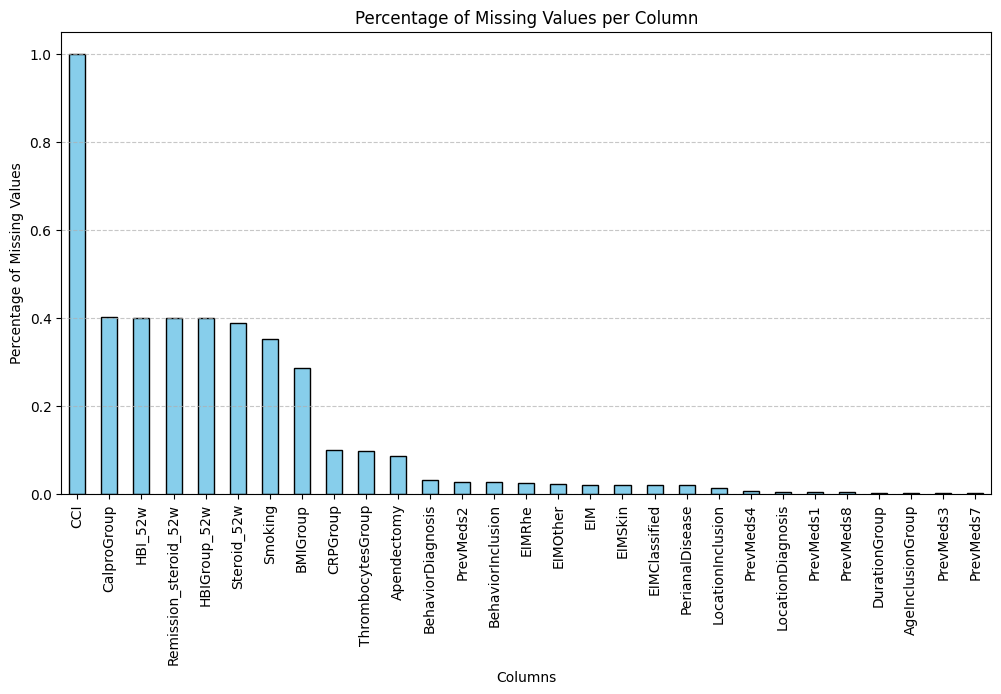

In [37]:
# Step 2: Identify high missing values using IQR method
q1 = np.percentile(missing_values, 25)
q3 = np.percentile(missing_values, 75)
iqr_value = iqr(missing_values)
upper_bound = q3 + 1.5 * iqr_value

# Identify columns with high missing values
high_missing_columns = missing_values[missing_values > upper_bound].index.tolist()

# Step 3: Visualize missing value percentages using a bar plot
plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percentage of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
# Remove columns with too many missing values or irrelevant information
# These columns either have high missing data or aren't useful for analysis:
columns_to_drop = [
    'ID', 'CCI', 'EIMRhe', 'EIMSkin', 'EIMOther', 'EIMClassified', 'PrevMeds1', 'PrevMeds2',
    'PrevMeds3', 'PrevMeds4', 'PrevMeds5', 'PrevMeds6', 'PrevMeds7', 'PrevMeds8',
    'Steroid_52w', 'HBI_52w', 'HBIGroup_52w', 'Remission_steroid_52w']

# Remove the identified columns from the dataframe
icc_complete = icc_complete.drop(columns=columns_to_drop)

# Optional: Display remaining columns and their missing values
missing_values_after_drop = icc_complete.isnull().mean()
missing_values_after_drop = missing_values_after_drop.sort_values(ascending=False)

print("Remaining columns with missing values:")
print(missing_values_after_drop)

Remaining columns with missing values:
CalproGroup          0.402685
Smoking              0.351230
BMIGroup             0.286353
CRPGroup             0.098434
ThrombocytesGroup    0.096197
Apendectomy          0.085011
BehaviorDiagnosis    0.031320
BehaviorInclusion    0.026846
PerianalDisease      0.020134
EIM                  0.020134
LocationInclusion    0.013423
LocationDiagnosis    0.004474
AgeInclusionGroup    0.002237
DurationGroup        0.002237
CancerEver           0.000000
PriorSurgery         0.000000
Remission_52w        0.000000
Medicine             0.000000
Gender               0.000000
AgeDiagnosisGroup    0.000000
PrevMeds             0.000000
dtype: float64


# **2. Train and test data**

In [39]:
# icc_complete
icc_c_train, icc_c_test = train_test_split(icc_complete, test_size=0.3, random_state=42, stratify=icc_complete.Remission_52w)

## **Statistics of the data**

In [40]:
def basic_statistics(col):
    print(f"\n{'='*20} Statistics for {col} {'='*20}\n")
    
    # Create DataFrames for train and test statistics
    def get_statistics(data, name):
        value_counts = data[col].value_counts()
        percentages = (value_counts / len(data)) * 100
        
        # Create DataFrame with counts and percentages
        stats_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage (%)': percentages.round(2)
        })
        
        # Add null values
        null_count = data[col].isnull().sum()
        null_percentage = (null_count / len(data)) * 100
        
        if null_count > 0:
            stats_df.loc['Null'] = [null_count, null_percentage.round(2)]
            
        stats_df.index.name = 'Value'
        stats_df['Dataset'] = name
        
        return stats_df
    
    # Get statistics for train and test
    train_stats = get_statistics(icc_c_train, 'Train')
    test_stats = get_statistics(icc_c_test, 'Test')
    
    # Combine train and test statistics
    combined_stats = pd.concat([train_stats, test_stats])
    combined_stats = combined_stats.reset_index()
    
    # Create a pivot table for side-by-side comparison
    pivot_stats = combined_stats.pivot(index='Value', 
                                     columns='Dataset', 
                                     values=['Count', 'Percentage (%)'])
    
    # Format the pivot table
    print("Distribution Statistics:")
    print(pivot_stats.round(2))
    
    # Perform t-test
    t_statistic, p_value = ttest_ind(icc_c_train[col], 
                                    icc_c_test[col], 
                                    nan_policy='omit')
    
    print(f"\nT-test Results:")
    t_test_df = pd.DataFrame({
        'Metric': ['T-statistic', 'P-value'],
        'Value': [t_statistic, p_value]
    }).set_index('Metric')
    
    print(t_test_df.round(4))


#for col in icc_complete.columns:
#    basic_statistics(col)

# **3.  Mode Imputation + Up-sampling**

### Impute with the mode value

In [41]:
# Function to Impute Missing Values
def impute_missing_values(data):
    """Imputes missing values using the most frequent value in each column."""
    imputer = SimpleImputer(strategy='most_frequent')
    transformed_values = imputer.fit_transform(data)  
    imputed_data = pd.DataFrame(transformed_values, index=data.index, columns=data.columns)

    
    return imputed_data

# Apply Imputation
icc_c_train_mode = impute_missing_values(icc_c_train)
icc_c_test_mode = impute_missing_values(icc_c_test)

In [42]:
"""
As SMOTENC requires both numerical and categorical features to work,
a  fix_type function is created to properly handle both numerical and
categorical columns.
"""

def fix_type(data):
    # Convert Remission_52w to integer type (0 or 1)
    data['Remission_52w'] = data['Remission_52w'].astype(int)
    #  Convert appropriate columns to categorical
    categorical_cols = [
    'AgeInclusionGroup', 'DurationGroup', 'BMIGroup2', 'Smoking', 
    'Gender', 'LocationDiagnosis', 'LocationInclusion', 'BehaviorDiagnosis', 'BehaviorInclusion',
    'CalproGroup', 'CRPGroup', 'ThrombocytesGroup', 'Apendectomy',  
    'EIM', 'PerianalDisease']

    # Define numerical columns (add your numerical columns here)
    numerical_cols = [
        'CancerEver', 'PriorSurgery', 'Medicine', 
        'PrevMeds', 'AgeDiagnosisGroup', 
    ]
    
    # Convert categorical columns to category dtype
    for col in categorical_cols:
        if col in data.columns:  # Check if column exists
            data[col] = data[col].astype('category')
    
    # Ensure numerical columns remain as float
    for col in numerical_cols:
        if col in data.columns:  # Check if column exists
            data[col] = data[col].astype(float)
    
    return data

# Convert
icc_c_train_mode= fix_type(icc_c_train_mode)

In [43]:
 # Step 3: Separate Features (X) and Target (y)
X_train = icc_c_train_mode.drop(columns=['Remission_52w'])
y_train = icc_c_train_mode['Remission_52w'].astype(int)  # Ensure y is numeric


# Step 2: Identify categorical features for SMOTENC
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]


# Step 4: Apply SMOTENC for Up-Sampling
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

# Step 5: Convert Back to DataFrame
upsampled_train = pd.DataFrame(X_resampled, columns=X_train.columns)
upsampled_train['Remission_52w'] = y_resampled  # Add target column back

# Step 6: Verify Up-Sampling
print("Original Class Distribution:\n", y_train.value_counts())
print("Resampled Class Distribution:\n", y_resampled.value_counts())


Original Class Distribution:
 Remission_52w
0    198
1    114
Name: count, dtype: int64
Resampled Class Distribution:
 Remission_52w
1    198
0    198
Name: count, dtype: int64


In [44]:
# re-Convert all predictors to cCategory 
def tocCategory(data):
    # Convert Remission_52w to integer type (0 or 1)
    data['Remission_52w'] = data['Remission_52w'].astype(int)
    #  Convert appropriate columns to categorical
    categorical_cols = [
    'AgeInclusionGroup', 'DurationGroup', 'BMIGroup2', 'Smoking', 
    'Gender', 'LocationDiagnosis', 'LocationInclusion', 'BehaviorDiagnosis', 'BehaviorInclusion',
    'CalproGroup', 'CRPGroup', 'ThrombocytesGroup', 'Apendectomy',  
    'EIM', 'PerianalDisease',
        'CancerEver', 'PriorSurgery', 'Medicine', 
        'PrevMeds', 'AgeDiagnosisGroup', 
    ]
    
    # Convert categorical columns to category dtype
    for col in categorical_cols:
        if col in data.columns:  # Check if column exists
            data[col] = data[col].astype('category')

    
    return data

# Convert
icc_c_train_mode= tocCategory(icc_c_train_mode)
icc_c_test_mode = tocCategory(icc_c_test_mode)
upsampled_train = tocCategory(upsampled_train)

In [45]:
upsampled_train.dtypes

Medicine             category
AgeDiagnosisGroup    category
AgeInclusionGroup    category
DurationGroup        category
BMIGroup              float64
Smoking              category
Gender               category
LocationDiagnosis    category
LocationInclusion    category
BehaviorDiagnosis    category
BehaviorInclusion    category
CalproGroup          category
CRPGroup             category
ThrombocytesGroup    category
Apendectomy          category
CancerEver           category
PriorSurgery         category
EIM                  category
PerianalDisease      category
PrevMeds             category
Remission_52w           int64
dtype: object

# **_4 Expert Network_**


creates a Bayesian Network object based on expert knowledge, visualizes it, and saves it as a JSON file

In [46]:


# Define the edges for the expert model based on expert knowledge
edges = [
    ('AgeDiagnosisGroup', 'Remission_52w'), ('AgeDiagnosisGroup', 'Apendectomy'), 
    ('AgeDiagnosisGroup', 'CancerEver'), ('AgeDiagnosisGroup', 'PriorSurgery'), 
    ('AgeInclusionGroup', 'Smoking'), ('AgeInclusionGroup', 'Medicine'),
    ('AgeInclusionGroup', 'CancerEver'), ('AgeInclusionGroup', 'BMIGroup'),
    ('AgeInclusionGroup', 'PriorSurgery'),
    ('DurationGroup', 'Remission_52w'), ('DurationGroup', 'PriorSurgery'), 
    ('DurationGroup', 'LocationInclusion'), ('DurationGroup', 'BehaviorInclusion'),
    ('Gender', 'Smoking'), ('Gender', 'Remission_52w'),
    ('LocationDiagnosis', 'PerianalDisease'), ('LocationDiagnosis', 'CancerEver'), 
    ('LocationInclusion', 'PerianalDisease'), ('LocationInclusion', 'CancerEver'),
    ('LocationInclusion', 'CalproGroup'),
    ('BehaviorDiagnosis', 'PriorSurgery'),
    ('BehaviorInclusion', 'CRPGroup'), ('BehaviorInclusion', 'PriorSurgery'), 
    ('Smoking', 'PerianalDisease'), ('Smoking', 'Remission_52w'), ('Smoking', 'BMIGroup'), 
    ('Smoking', 'BehaviorInclusion'), ('Smoking', 'CancerEver'),
    ('CalproGroup', 'Remission_52w'), 
    ('CRPGroup', 'Remission_52w'),
    ('ThrombocytesGroup', 'Remission_52w'), 
    ('PriorSurgery', 'Remission_52w'),
    ('EIM', 'Medicine'), 
    ('PrevMeds', 'Medicine'), ('PrevMeds', 'Remission_52w'),
    ('PerianalDisease', 'Remission_52w'), ('PerianalDisease', 'Medicine'), 
    ('PerianalDisease', 'CRPGroup')
]

# Create the Bayesian Network (DAG) from the expert-defined edges
expert_model = DAG(edges)

# Print the edges of the created DAG for inspection
print("Edges of the Expert Model:")
print(expert_model.edges())

# Convert the expert model to a NetworkX graph for visualization
nx_graph_x = nx.DiGraph(expert_model.edges())


Edges of the Expert Model:
[('AgeDiagnosisGroup', 'Remission_52w'), ('AgeDiagnosisGroup', 'Apendectomy'), ('AgeDiagnosisGroup', 'CancerEver'), ('AgeDiagnosisGroup', 'PriorSurgery'), ('PriorSurgery', 'Remission_52w'), ('AgeInclusionGroup', 'Smoking'), ('AgeInclusionGroup', 'Medicine'), ('AgeInclusionGroup', 'CancerEver'), ('AgeInclusionGroup', 'BMIGroup'), ('AgeInclusionGroup', 'PriorSurgery'), ('Smoking', 'PerianalDisease'), ('Smoking', 'Remission_52w'), ('Smoking', 'BMIGroup'), ('Smoking', 'BehaviorInclusion'), ('Smoking', 'CancerEver'), ('DurationGroup', 'Remission_52w'), ('DurationGroup', 'PriorSurgery'), ('DurationGroup', 'LocationInclusion'), ('DurationGroup', 'BehaviorInclusion'), ('LocationInclusion', 'PerianalDisease'), ('LocationInclusion', 'CancerEver'), ('LocationInclusion', 'CalproGroup'), ('BehaviorInclusion', 'CRPGroup'), ('BehaviorInclusion', 'PriorSurgery'), ('Gender', 'Smoking'), ('Gender', 'Remission_52w'), ('LocationDiagnosis', 'PerianalDisease'), ('LocationDiagnosis

In [47]:
# Source nodes have the same color as their edges.
# The target node (Remission_52w) is coral.
# Other non-source nodes are light blue.

# Define source nodes
source_nodes = [
    'AgeDiagnosisGroup', 'AgeInclusionGroup', 'DurationGroup', 'Gender',
    'LocationDiagnosis', 'LocationInclusion', 'BehaviorDiagnosis', 'BehaviorInclusion',
    'Smoking', 'CalproGroup', 'CRPGroup', 'ThrombocytesGroup', 'PriorSurgery',
    'EIM', 'PrevMeds', 'PerianalDisease'
]

# Generate a color palette using a colormap
cmap = cm.get_cmap('Set3', len(source_nodes))
colors = {node: mcolors.to_hex(cmap(i)) for i, node in enumerate(source_nodes)}

# Define the plot function
def plotGraph(model, title, figsize,k):
    nx_graph = nx.DiGraph(model.edges())
    formatted_labels = {node: re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', node).replace('_', ' ') for node in nx_graph.nodes()}

    # Determine node colors:
    node_color = {}
    for node in nx_graph.nodes():
        if node == 'Remission_52w':  # Target node
            node_color[node] = 'coral'
        elif node in source_nodes:  # Source nodes get their assigned color
            node_color[node] = colors[node]
        else:  # Non-source, non-target nodes
            node_color[node] = 'lightblue'

    # Assign colors dynamically for edges
    edge_colors = [colors.get(u, 'gray') for u, v in nx_graph.edges()]

    pos = nx.spring_layout(nx_graph, k=k, seed=42, iterations=300)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(nx_graph, pos, node_color=[node_color[n] for n in nx_graph.nodes()], node_size=1000)
    nx.draw_networkx_edges(nx_graph, pos, edge_color=edge_colors, width=3.5, alpha=1, arrows=True, arrowsize=30)
    nx.draw_networkx_labels(nx_graph, pos, labels=formatted_labels, font_weight='bold', font_size=13, font_color='black')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()


<ipython-input-47-bf0e33ccefbf>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(source_nodes))


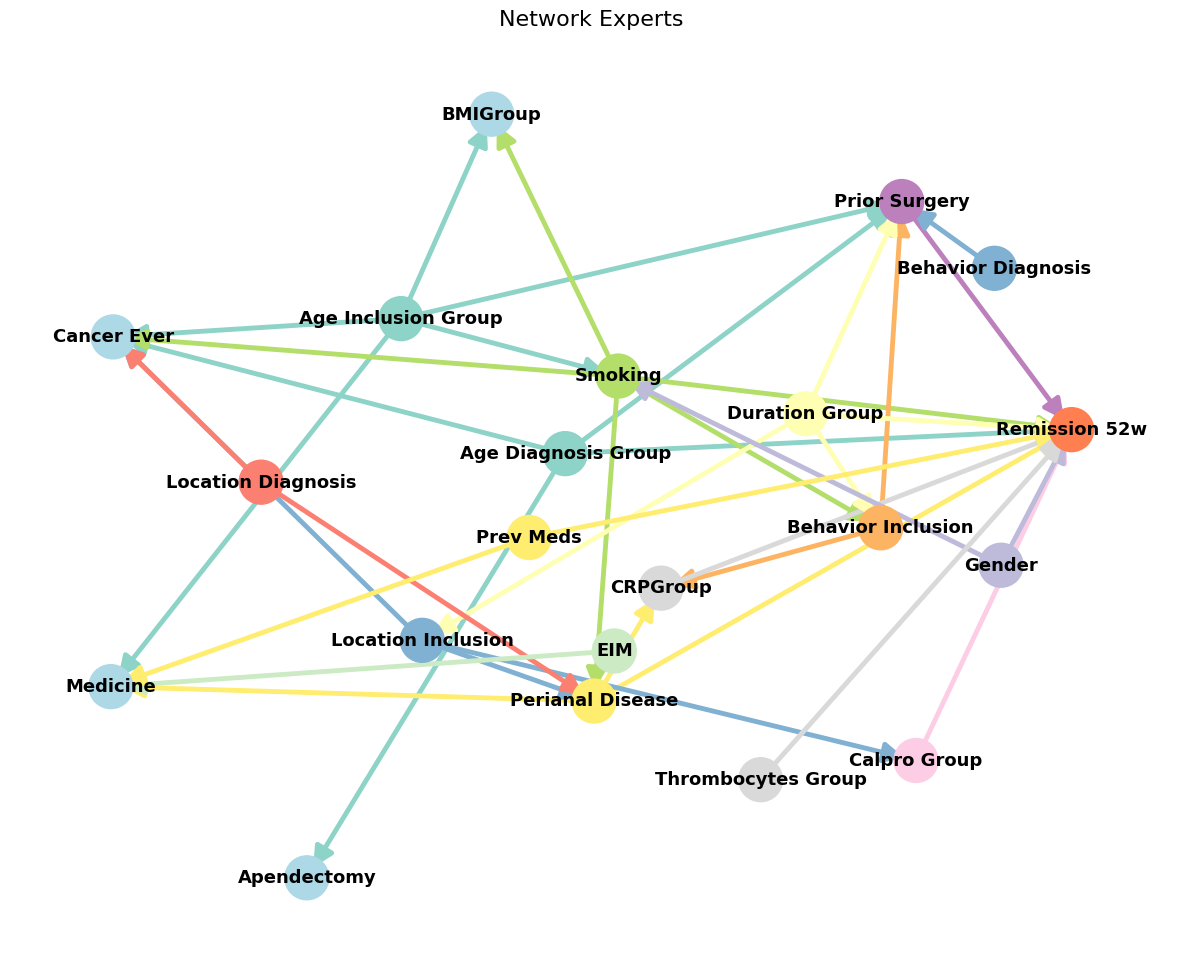

The expert model has been saved as a JSON file at: expert_model.json


In [48]:
plotGraph(nx_graph_x, "Network Experts",  (15, 12),5)

# Save the visualization as a JSON file for further use or sharing
#file_path = "C:/Users/maikk/Documents/uni/thesis/master-thesis-CD/BayesianNetworkICC/DAGs/"
file_x = 'expert_model.json' #file_path + 'expert_model.json'

# Export the graph as a JSON file
json_x = json.dumps(nx.cytoscape_data(nx_graph_x), indent=2)
with open(file_x, 'w') as file:
    file.write(json_x)

print(f"The expert model has been saved as a JSON file at: {file_x}")

# **_5. Structure Learning Expert HC ICC_**

The following process aims to apply the Hill Climb Search (HCS) method to structure learning, exploring the best network structure for the given data using different scoring methods. It involves several stages: initializing the search algorithm, defining scoring methods, applying blacklists and whitelists for edges, and searching for the best structure using different scoring methods. After that, the best structures are visualized as directed graphs, and the results are saved in JSON format for use in Cytoscape for further manipulation and visualization

In [49]:

# Define the state names for categorical variables to guide the learning process
state_names = {
    'DurationGroup': [1, 2, 3,4],
    'EIM': [0, 1, 2, 3, 4, 5, 6, 7],
    'PrevMeds': [0, 1, 2 ,3]
}

# Initialize Hill Climb Search with the training data
hill_climb = HillClimbSearch(data=upsampled_train)

# Define scoring methods for the structure learning process
scoring_methods = {
    'bic': BicScore(data=upsampled_train),
    'k2': K2Score(data=upsampled_train),
    'bdeu': BDeuScore(data=upsampled_train),
    'bds': BDsScore(data=upsampled_train)
}

# Extract columns excluding the target variable
cols = upsampled_train.columns.drop('Remission_52w')

# Initialize blacklists for restricted edges
black_list = []

# Blacklist all edges originating from 'Remission_52w'
for col in upsampled_train.columns:
    edge = ('Remission_52w', col)
    black_list.append(edge)
black_list.remove(('Remission_52w', 'Remission_52w'))  # Remove self-loop

# Blacklist edges from any column to basic columns
basic_cols = ['Gender', 'AgeDiagnosisGroup', 'AgeInclusionGroup', 'DurationGroup']
for col in upsampled_train.columns:
    for b_col in basic_cols:
        if col != b_col:
            edge = (col, b_col)
            black_list.append(edge)

# Blacklist edges that source from events occurring after the target
prior_cols = ['CancerEver', 'PriorSurgery', 'Smoking', 'PrevMeds', 'Appendectomy', 'LocationDiagnosis', 'BehaviorDiagnosis']
incl_cols = ['EIM', 'BMIGroup', 'CRPGroup', 'CalproGroup', 'ThrombocytesGroup', 'Medicine', 'LocationInclusion', 
             'BehaviorInclusion', 'PerianalDisease']

for p_col in prior_cols:
    for i_col in incl_cols:
        edge = (i_col, p_col)
        black_list.append(edge)

# Define the whitelist as the edges from the expert model
white_list = expert_model.edges()

# Prepare multiple copies of the expert model for different scoring methods
start_dags = {
    'k2': expert_model.copy(),
    'bic': expert_model.copy(),
    'bdeu': expert_model.copy(),
    'bds': expert_model.copy()
}

# Perform structure learning using Hill Climb Search with different scoring methods
best_models = {}
for method, dag in start_dags.items():
    best_models[method] = hill_climb.estimate(scoring_method=scoring_methods[method], 
                                               start_dag=dag, 
                                               black_list=black_list, 
                                               white_list=white_list)


# Saving the graphs as JSON for Cytoscape visualization
def save_graph_json(graph, file_name):
    """Saves the graph data in Cytoscape-compatible JSON format."""
    #file_path = "C:/Users/maikk/Documents/uni/thesis/master-thesis-CD/BayesianNetworkICC/DAGs/"
    json_data = json.dumps(nx.cytoscape_data(graph), indent=2)
    with open( file_name, 'w') as file: # file_path +
        file.write(json_data)

# Saving the models as JSON files
save_graph_json(nx.DiGraph(best_models['k2'].edges()), 'k2_x.json')
save_graph_json(nx.DiGraph(best_models['bic'].edges()), 'bic_x.json')
save_graph_json(nx.DiGraph(best_models['bdeu'].edges()), 'bdeu_x.json')
save_graph_json(nx.DiGraph(best_models['bds'].edges()), 'bds_x.json')

print("The models have been saved as JSON files for Cytoscape visualization.")


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

The models have been saved as JSON files for Cytoscape visualization.


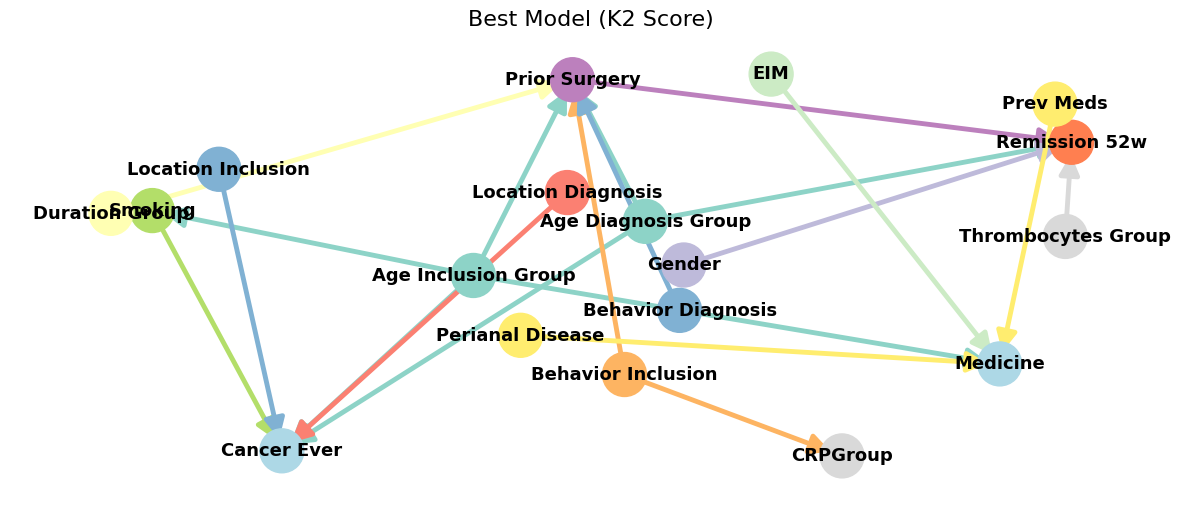

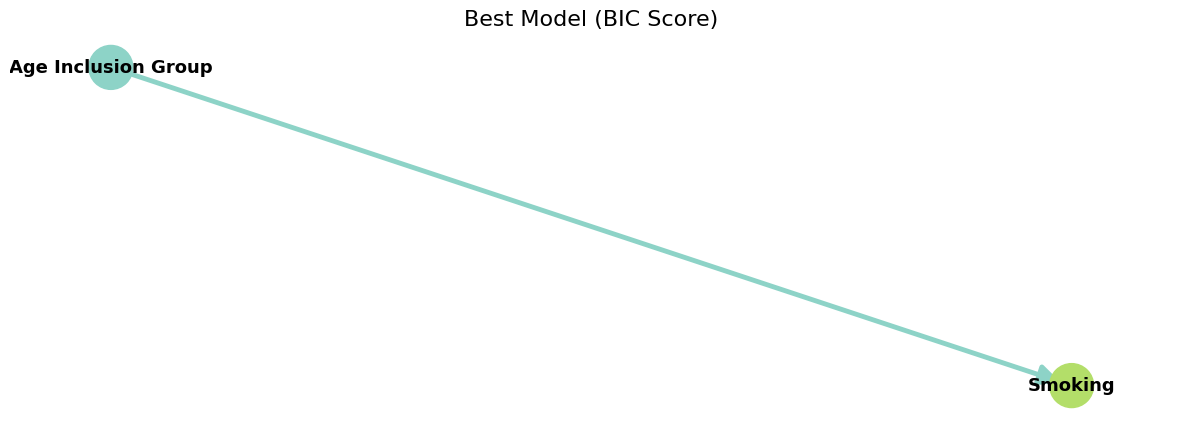

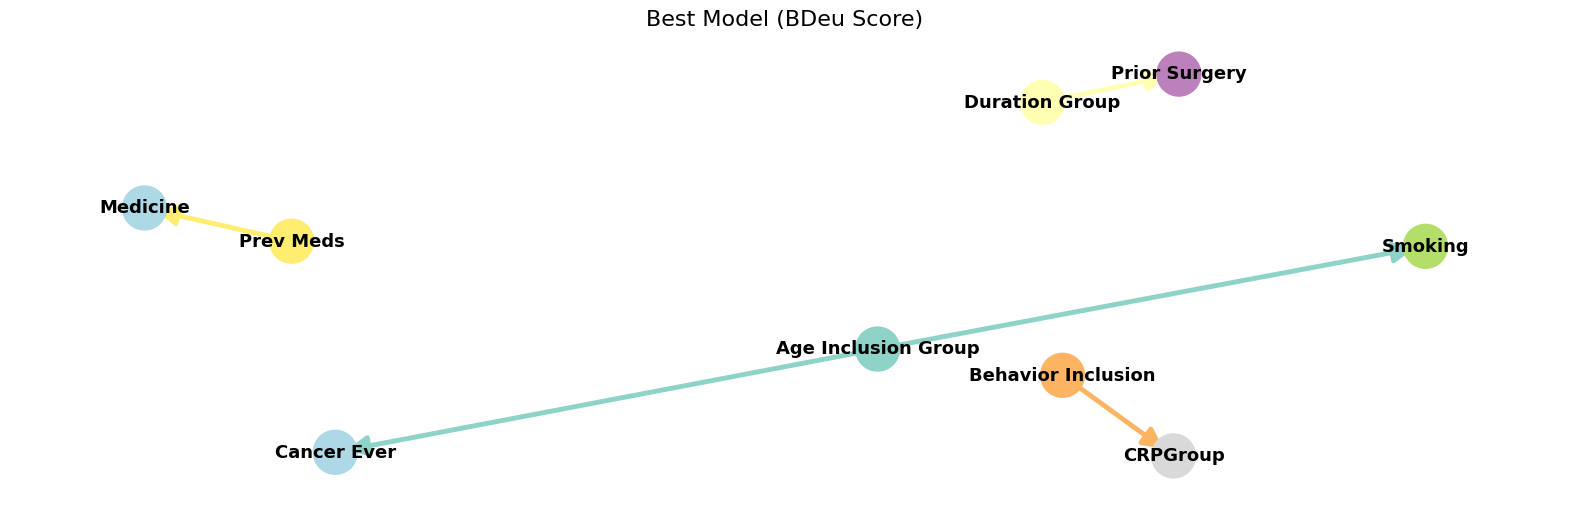

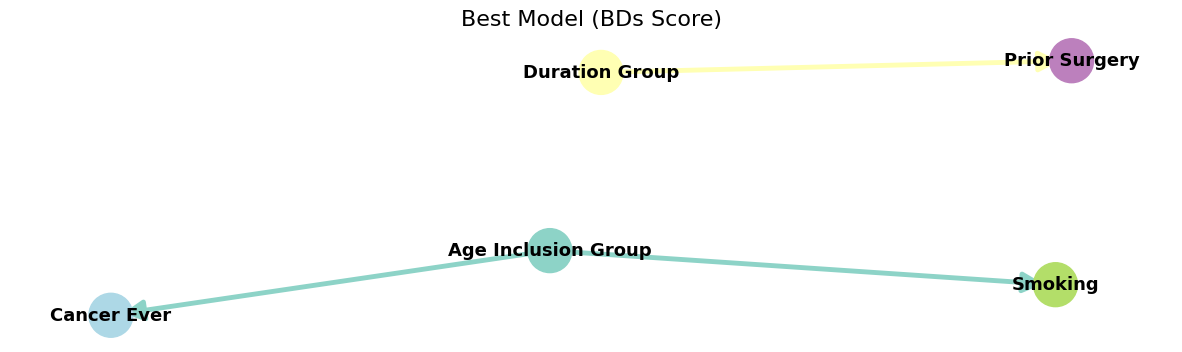

In [50]:
# Visualizing the best models for each scoring method with the same style
plotGraph(best_models['k2'], "Best Model (K2 Score)",  (15, 6),5)
plotGraph(best_models['bic'], "Best Model (BIC Score)",(15, 5),4)
plotGraph(best_models['bdeu'], "Best Model (BDeu Score)", (20, 6),2)
plotGraph(best_models['bds'], "Best Model (BDs Score)", (15, 4),5)

# **_6. Bayesian Network ICC_**

### **Step 1: Define and Train Bayesian Networks**

We begin by constructing two Bayesian Networks: one using a data-driven structure (`best_model_k2`) and another based on expert knowledge (`expert_model`). Both networks are trained using Bayesian Estimation with a Dirichlet prior (`BDeu`) and an equivalent sample size of 1.

In [51]:
# 1.  Bayesian Networks
# Data-driven Bayesian Network
bn = BayesianNetwork(best_models['k2'].edges())
bn.fit(
    data=upsampled_train,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=1
)

# Expert-defined Bayesian Network
bn_expert = BayesianNetwork(expert_model.edges())
bn_expert.fit(
    data=upsampled_train,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=1
)

# Display Conditional Probability Distribution for a target variable
print(bn.get_cpds('Remission_52w'))


+-------------------+------------------------+-----+------------------------+
| AgeDiagnosisGroup | AgeDiagnosisGroup(1.0) | ... | AgeDiagnosisGroup(4.0) |
+-------------------+------------------------+-----+------------------------+
| Gender            | Gender(1.0)            | ... | Gender(2.0)            |
+-------------------+------------------------+-----+------------------------+
| PriorSurgery      | PriorSurgery(0.0)      | ... | PriorSurgery(1.0)      |
+-------------------+------------------------+-----+------------------------+
| ThrombocytesGroup | ThrombocytesGroup(1.0) | ... | ThrombocytesGroup(5.0) |
+-------------------+------------------------+-----+------------------------+
| Remission_52w(0)  | 0.5                    | ... | 0.5                    |
+-------------------+------------------------+-----+------------------------+
| Remission_52w(1)  | 0.5                    | ... | 0.5                    |
+-------------------+------------------------+-----+------------

In [52]:
# 2. Train Naïve Bayes Model

from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder

# Separate features and target
X_train = upsampled_train.drop(columns=['Remission_52w'])
y_train = upsampled_train['Remission_52w']

# Encode categorical features as numerical values for Naïve Bayes
X_train_encoded = X_train.apply(LabelEncoder().fit_transform)

# Train Naïve Bayes Model
nb_model = CategoricalNB()
nb_model.fit(X_train_encoded, y_train)


CategoricalNB()

### **Step 2: Identifying Missing Columns in the Bayesian Network**

Some columns present in the dataset may have been excluded during structure learning. We identify these missing columns and store them for later preprocessing.

In [53]:
abs_cols_bn = [col for col in upsampled_train.columns if col not in bn]

for col in abs_cols_bn:
    print(col)


abs_cols_bnExpert = [col for col in upsampled_train.columns if col not in bn_expert]

BMIGroup
CalproGroup
Apendectomy


### **Step 3: Preprocessing Test and Training Data**

To ensure compatibility with the Bayesian Network, we remove the excluded columns and use imputed versions of the datasets since Bayesian Network algorithms do not handle missing values.

In [54]:
bn_test_data_mode = icc_c_test_mode.drop(columns=abs_cols_bn)
bn_train_data_mode = icc_c_train_mode.drop(columns=abs_cols_bn)

bnExpert_test_data_mode = icc_c_test_mode.drop(columns=abs_cols_bnExpert)
bnExpert_train_data_mode = icc_c_train_mode.drop(columns=abs_cols_bnExpert)

### **Step 4: Evaluating Bayesian Network Performance**

We assess how well the Bayesian Network structure represents correlations in the data using correlation scores and structure scores.

In [55]:
# Compute scores for bn
#correlation_bn = correlation_score(bn, bn_test_data_mode, test='chi_square', significance_level=0.05)
structure_bn = structure_score(bn, bn_test_data_mode, scoring_method='k2')

# Compute scores for bn_expert
#correlation_bn_expert = correlation_score(bn_expert, bnExpert_test_data_mode, test='chi_square', significance_level=0.05)
structure_bn_expert = structure_score(bn_expert, bnExpert_test_data_mode, scoring_method='k2')

# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    "Model": ["Data-Driven BN", "Expert BN"],
    #"Correlation Score (Chi-Square)": [correlation_bn, correlation_bn_expert],
    "Structure Score (K2)": [structure_bn, structure_bn_expert]
})

# Display as a table
results_df

,Model,Structure Score (K2)
0,Data-Driven BN,-2014.669142
1,Expert BN,-2318.857575


### **Step 5: Making Predictions and Computing ROC-AUC Score**

We use the trained Bayesian Network to predict probabilities and evaluate the model using the ROC-AUC metric.

In [58]:
# Remove the target variable from the test data
bn_test_data_mode_no_outcome = bn_test_data_mode.drop(columns=['Remission_52w'])
bnExpert_test_data_mode_no_outcome = bnExpert_test_data_mode.drop(columns=['Remission_52w'])

# Predict probabilities
bn_predicted_probs = bn.predict_probability(bn_test_data_mode_no_outcome)
bnExpert_predicted_probs = bn_expert.predict_probability(bnExpert_test_data_mode_no_outcome)
outcome = icc_c_test.Remission_52w

# Convert probabilities to binary predictions (Threshold = 0.5)
bn_preds = (bn_predicted_probs['Remission_52w_1'] >= 0.5).astype(int)
bnExpert_preds = (bnExpert_predicted_probs['Remission_52w_1'] >= 0.5).astype(int)

# NB
# Prepare test data for Naive Bayes
X_test = icc_c_test_mode.drop(columns=['Remission_52w'])
X_test_encoded = X_test.apply(LabelEncoder().fit_transform)
outcome = icc_c_test_mode.Remission_52w

# Get probability predictions from Naive Bayes
nb_predicted_probs = nb_model.predict_proba(X_test_encoded)
nb_predicted_probs_positive = nb_predicted_probs[:, 1]  # Probability of positive class

# Convert probabilities to binary predictions (Threshold = 0.5)
nb_preds = (nb_predicted_probs_positive >= 0.5).astype(int)


In [59]:


# Compute accuracy
bn_accuracy = accuracy_score(outcome, bn_preds)
bnExpert_accuracy = accuracy_score(outcome, bnExpert_preds)

# Compute AUC (already calculated before)
bn_auc = roc_auc_score(outcome, bn_predicted_probs['Remission_52w_1'])
bnExpert_auc = roc_auc_score(outcome, bnExpert_predicted_probs['Remission_52w_1'])

# Compute Confusion Matrix values
bn_cm = confusion_matrix(outcome, bn_preds)
bnExpert_cm = confusion_matrix(outcome, bnExpert_preds)

# Extract True Positives, False Positives, True Negatives, and False Negatives
bn_TN, bn_FP, bn_FN, bn_TP = bn_cm.ravel()
bnExpert_TN, bnExpert_FP, bnExpert_FN, bnExpert_TP = bnExpert_cm.ravel()

# Compute Sensitivity (Recall)
bn_sensitivity = bn_TP / (bn_TP + bn_FN)
bnExpert_sensitivity = bnExpert_TP / (bnExpert_TP + bnExpert_FN)

# Compute Specificity
bn_specificity = bn_TN / (bn_TN + bn_FP)
bnExpert_specificity = bnExpert_TN / (bnExpert_TN + bnExpert_FP)





# Compute accuracy
nb_accuracy = accuracy_score(outcome, nb_preds)

# Compute AUC
nb_auc = roc_auc_score(outcome, nb_predicted_probs_positive)

# Compute Confusion Matrix values
nb_cm = confusion_matrix(outcome, nb_preds)

# Extract True Positives, False Positives, True Negatives, and False Negatives
nb_TN, nb_FP, nb_FN, nb_TP = nb_cm.ravel()

# Compute Sensitivity (Recall)
nb_sensitivity = nb_TP / (nb_TP + nb_FN)

# Compute Specificity
nb_specificity = nb_TN / (nb_TN + nb_FP)

# Update the results DataFrame to include Naive Bayes
results_df = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Sensitivity (Recall)", "Specificity"],
    "Data-Driven BN": [bn_accuracy, bn_auc, bn_sensitivity, bn_specificity],
    "Expert BN": [bnExpert_accuracy, bnExpert_auc, bnExpert_sensitivity, bnExpert_specificity],
    "Naive Bayes": [nb_accuracy, nb_auc, nb_sensitivity, nb_specificity]
})

# Display the results table
results_df

,Metric,Data-Driven BN,Expert BN,Naive Bayes
0,Accuracy,0.481481,0.437037,0.392593
1,AUC,0.434941,0.479882,0.550118
2,Sensitivity (Recall),0.320000,0.920000,0.880000
3,Specificity,0.576471,0.152941,0.105882


### **Step 6: Plotting the ROC Curve**

The ROC curve helps visualize the trade-off between sensitivity and specificity.

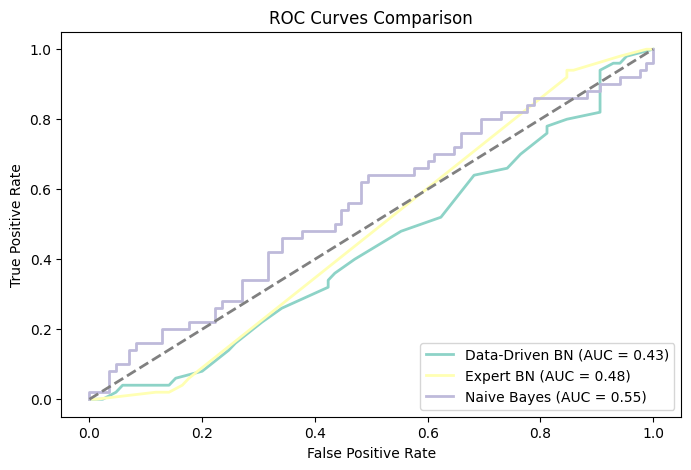

In [60]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves for all three models
bn_fpr, bn_tpr, _ = roc_curve(outcome, bn_predicted_probs['Remission_52w_1'])
bn_auc = auc(bn_fpr, bn_tpr)

bnExpert_fpr, bnExpert_tpr, _ = roc_curve(outcome, bnExpert_predicted_probs['Remission_52w_1'])
bnExpert_auc = auc(bnExpert_fpr, bnExpert_tpr)

nb_fpr, nb_tpr, _ = roc_curve(outcome, nb_predicted_probs_positive)
nb_auc = auc(nb_fpr, nb_tpr)

# Use Set3 color palette from seaborn for three models
colors = sns.color_palette("Set3", 3)  # Get three colors from Set3

# Plot ROC Curves
plt.figure(figsize=(8, 5))
plt.plot(bn_fpr, bn_tpr, color=colors[0], lw=2, label=f'Data-Driven BN (AUC = {bn_auc:.2f})')
plt.plot(bnExpert_fpr, bnExpert_tpr, color=colors[1], lw=2, label=f'Expert BN (AUC = {bnExpert_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, color=colors[2], lw=2, label=f'Naive Bayes (AUC = {nb_auc:.2f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')

# Legend
plt.legend(loc='lower right')

# Show plot
plt.show()

### **Step 7: Confusion Matrix and Classification Report**

The confusion matrix provides a detailed breakdown of prediction performance.

<Figure size 800x600 with 0 Axes>

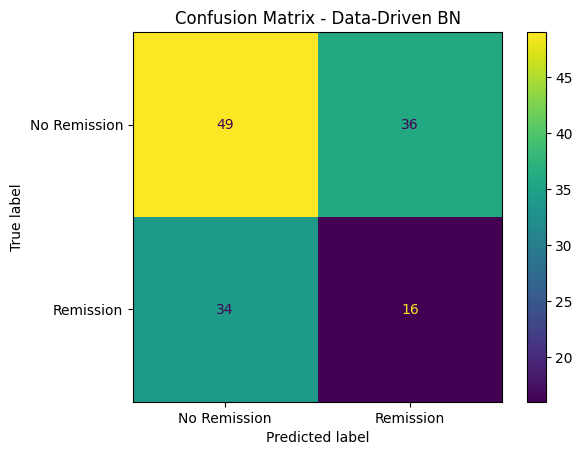


Classification Report - Data-Driven Bayesian Network:
              precision    recall  f1-score   support

           0       0.59      0.58      0.58        85
           1       0.31      0.32      0.31        50

    accuracy                           0.48       135
   macro avg       0.45      0.45      0.45       135
weighted avg       0.49      0.48      0.48       135



<Figure size 800x600 with 0 Axes>

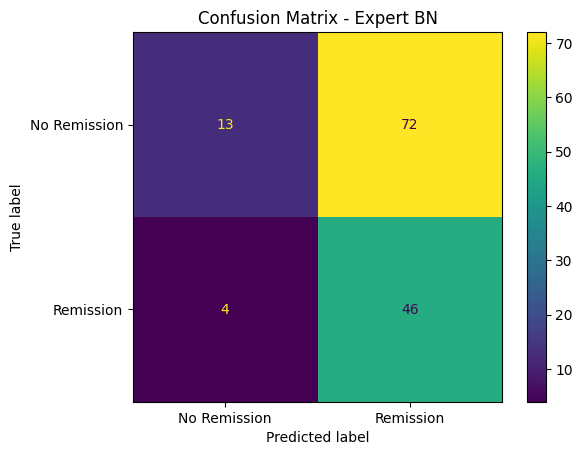


Classification Report - Expert Bayesian Network:
              precision    recall  f1-score   support

           0       0.76      0.15      0.25        85
           1       0.39      0.92      0.55        50

    accuracy                           0.44       135
   macro avg       0.58      0.54      0.40       135
weighted avg       0.63      0.44      0.36       135



<Figure size 800x600 with 0 Axes>

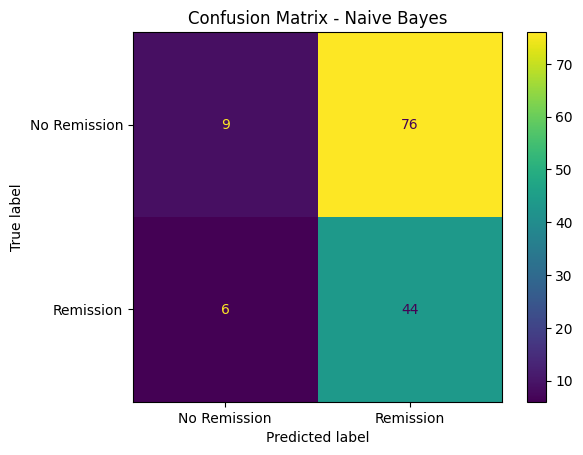


Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           0       0.60      0.11      0.18        85
           1       0.37      0.88      0.52        50

    accuracy                           0.39       135
   macro avg       0.48      0.49      0.35       135
weighted avg       0.51      0.39      0.31       135



In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Data-Driven Bayesian Network
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(outcome, bn_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Remission', 'Remission'])
disp.plot()
plt.title('Confusion Matrix - Data-Driven BN')
plt.show()

print("\nClassification Report - Data-Driven Bayesian Network:")
print(classification_report(outcome, bn_preds))

# Expert Bayesian Network
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(outcome, bnExpert_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Remission', 'Remission'])
disp.plot()
plt.title('Confusion Matrix - Expert BN')
plt.show()

print("\nClassification Report - Expert Bayesian Network:")
print(classification_report(outcome, bnExpert_preds))

# Naive Bayes
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(outcome, nb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Remission', 'Remission'])
disp.plot()
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

print("\nClassification Report - Naive Bayes:")
print(classification_report(outcome, nb_preds))

### **Step 8: Node Removal to Improve AUC-ROC Score**

We systematically remove nodes to evaluate their impact on AUC-ROC.

In [62]:
def compute_auc_after_node_removal(bn, train_data, test_data):
    best_auc, best_removed_node = 0, None
    results = []

    for node in bn.nodes:
        if node != 'Remission_52w':  # We don't remove the target variable
            temp_model = bn.copy()
            temp_model.remove_node(node)

            bayesian_network = BayesianNetwork(temp_model.edges)
            bayesian_network.fit(
                data=train_data,
                estimator=BayesianEstimator,
                prior_type="BDeu",
                equivalent_sample_size=1
            )

            if 'Remission_52w' in bayesian_network.nodes:
                prediction_data = test_data[[n for n in bayesian_network.nodes if n != 'Remission_52w']]
                predicted_probs = bayesian_network.predict_probability(prediction_data)
                auc_roc = roc_auc_score(test_data['Remission_52w'], predicted_probs['Remission_52w_1'])

                results.append([node, auc_roc])

                # Keep track of the best improvement
                if auc_roc > best_auc:
                    best_auc, best_removed_node = auc_roc, node

    return best_auc, best_removed_node, results

# Run for Data-Driven BN
bn_best_auc, bn_best_removed_node, bn_results = compute_auc_after_node_removal(
    bn, icc_c_train_mode, icc_c_test_mode
)

# Run for Expert BN
bnExpert_best_auc, bnExpert_best_removed_node, bnExpert_results = compute_auc_after_node_removal(
    bn_expert, icc_c_train_mode, icc_c_test_mode
)

# Create a DataFrame for results
df_results = pd.DataFrame({
    "Metric": ["Best AUC", "Best Node Removed"],
    "Data-Driven BN": [bn_best_auc, bn_best_removed_node],
    "Expert BN": [bnExpert_best_auc, bnExpert_best_removed_node],
    "Naive Bayes": [nb_auc, ""]
})

# Display the table
df_results


,Metric,Data-Driven BN,Expert BN,Naive Bayes
0,Best AUC,0.505765,0.568941,0.550118
1,Best Node Removed,ThrombocytesGroup,ThrombocytesGroup,


### **Step 9: Visualizing the Bayesian Network After Node Removal**

We draw the Bayesian Network after removing the best nodes

In [63]:
# Source nodes have the same color as their edges.
# The target node (Remission_52w) is coral.
# Other non-source nodes are light blue.

# Define source nodes
source_nodes = [
    'AgeDiagnosisGroup', 'AgeInclusionGroup', 'DurationGroup', 'Gender',
    'LocationDiagnosis', 'LocationInclusion', 'BehaviorDiagnosis', 'BehaviorInclusion',
    'Smoking', 'CalproGroup', 'CRPGroup',  'PriorSurgery',
    'EIM', 'PrevMeds', 'PerianalDisease'
]

# Generate a color palette using a colormap
cmap = cm.get_cmap('Set3', len(source_nodes))
colors = {node: mcolors.to_hex(cmap(i)) for i, node in enumerate(source_nodes)}

# Define the plot function
def plotGraph(model, title, figsize,k):
    nx_graph = nx.DiGraph(model.edges())
    formatted_labels = {node: re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', node).replace('_', ' ') for node in nx_graph.nodes()}

    # Determine node colors:
    node_color = {}
    for node in nx_graph.nodes():
        if node == 'Remission_52w':  # Target node
            node_color[node] = 'coral'
        elif node in source_nodes:  # Source nodes get their assigned color
            node_color[node] = colors[node]
        else:  # Non-source, non-target nodes
            node_color[node] = 'lightblue'

    # Assign colors dynamically for edges
    edge_colors = [colors.get(u, 'gray') for u, v in nx_graph.edges()]

    pos = nx.spring_layout(nx_graph, k=k, seed=42, iterations=300)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(nx_graph, pos, node_color=[node_color[n] for n in nx_graph.nodes()], node_size=1000)
    nx.draw_networkx_edges(nx_graph, pos, edge_color=edge_colors, width=3.5, alpha=1, arrows=True, arrowsize=30)
    nx.draw_networkx_labels(nx_graph, pos, labels=formatted_labels, font_weight='bold', font_size=13, font_color='black')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

<ipython-input-63-2026a08be894>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(source_nodes))


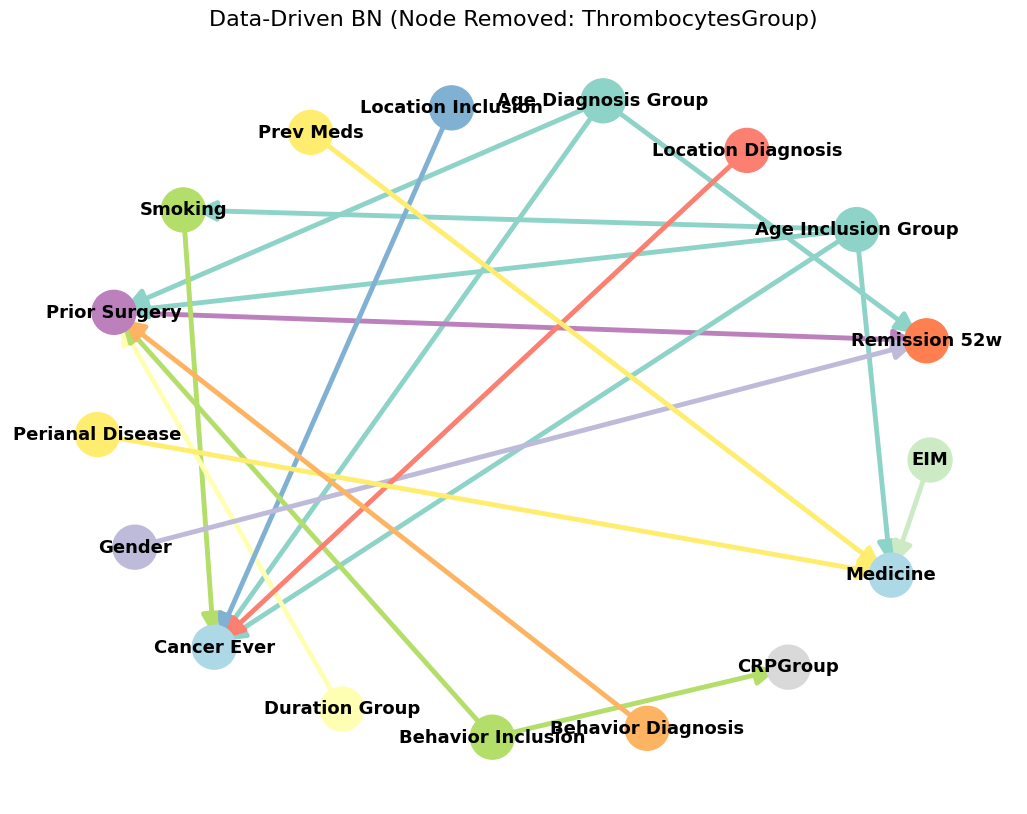

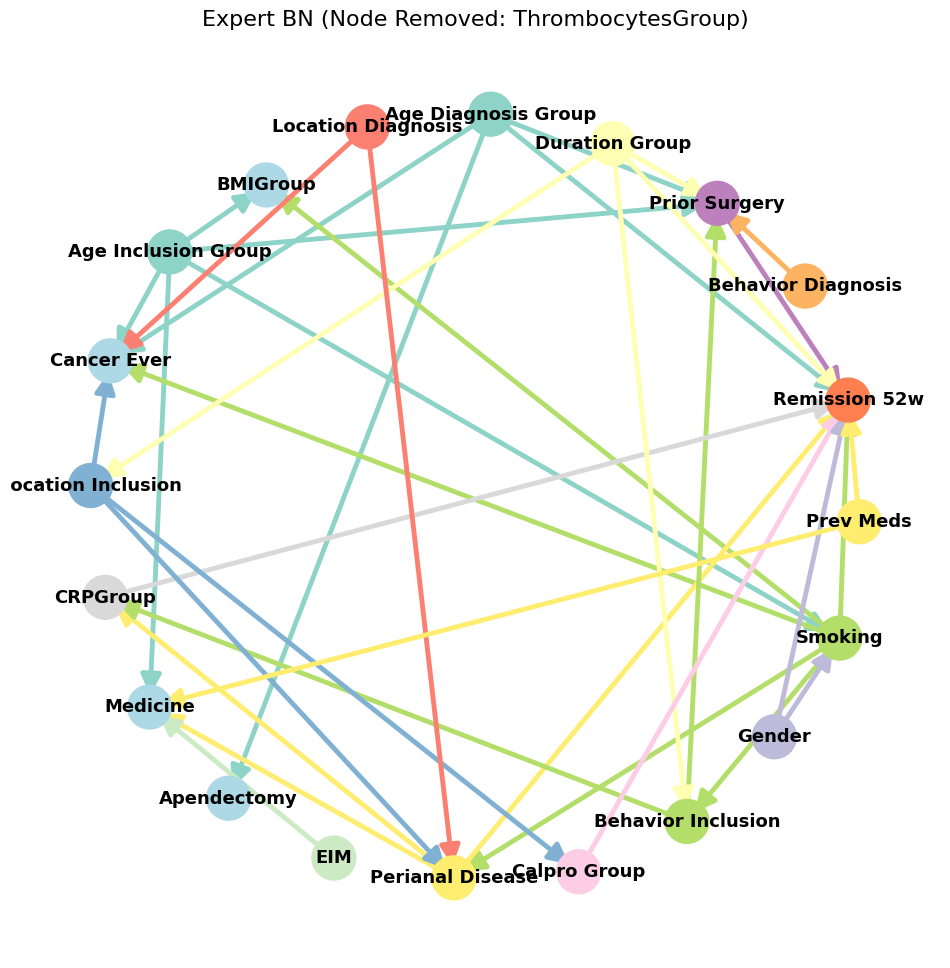

In [64]:
# For Data-Driven BN after removing best node
bn_temp_model = bn.copy()
bn_temp_model.remove_node(bn_best_removed_node)  # Remove the best node identified for Data-Driven BN
plotGraph(bn_temp_model, f'Data-Driven BN (Node Removed: {bn_best_removed_node})', figsize=(13, 10), k=20)

# For Expert BN after removing best node
bn_expert_temp_model = bn_expert.copy()
bn_expert_temp_model.remove_node(bnExpert_best_removed_node)  # Remove the best node identified for Expert BN
plotGraph(bn_expert_temp_model, f'Expert BN (Node Removed: {bnExpert_best_removed_node})', figsize=(12, 12), k=20)


# **7. Weighted Ensemble Voting Classifier**


Accuracy Weights:
Weights: ['0.367', '0.333', '0.299']
Accuracy: 0.474
AUC: 0.465
Sensitivity: 0.520
Specificity: 0.447


<Figure size 800x600 with 0 Axes>

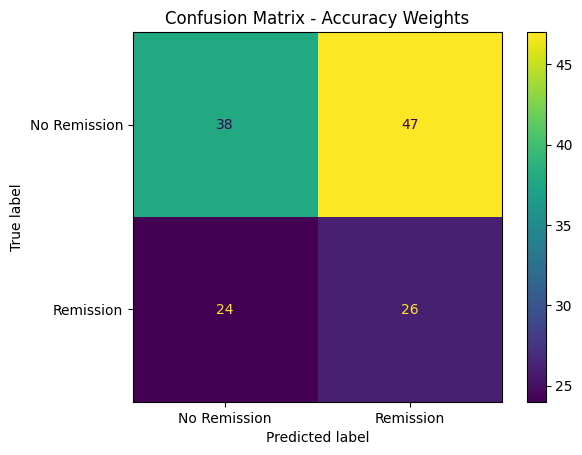


Auc Weights:
Weights: ['0.297', '0.328', '0.376']
Accuracy: 0.459
AUC: 0.481
Sensitivity: 0.660
Specificity: 0.341


<Figure size 800x600 with 0 Axes>

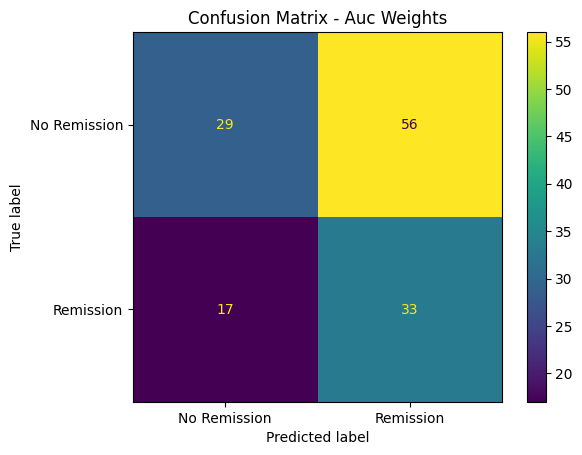


Sensitivity Weights:
Weights: ['0.151', '0.434', '0.415']
Accuracy: 0.481
AUC: 0.500
Sensitivity: 0.800
Specificity: 0.294


<Figure size 800x600 with 0 Axes>

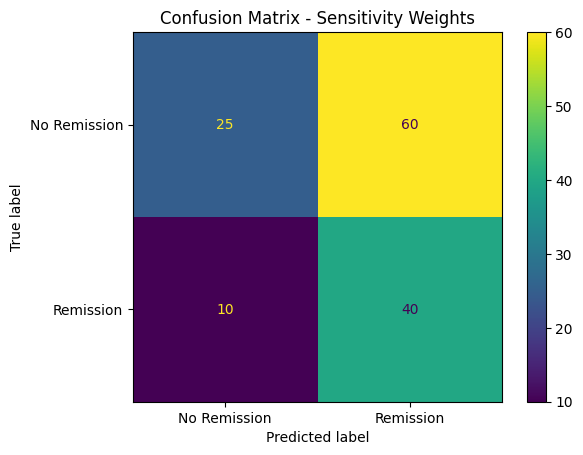


Specificity Weights:
Weights: ['0.690', '0.183', '0.127']
Accuracy: 0.519
AUC: 0.437
Sensitivity: 0.380
Specificity: 0.600


<Figure size 800x600 with 0 Axes>

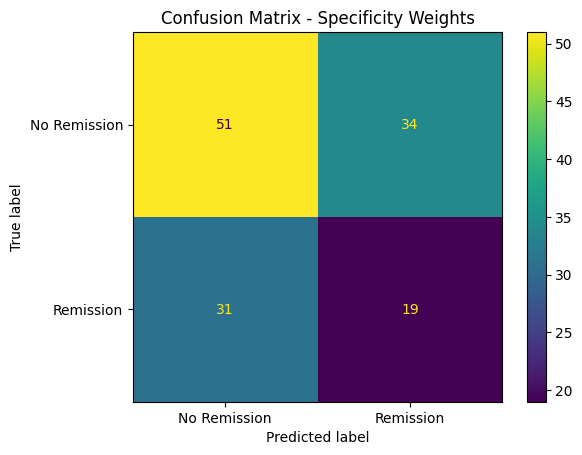


Balanced Weights:
Weights: ['0.316', '0.347', '0.336']
Accuracy: 0.444
AUC: 0.470
Sensitivity: 0.560
Specificity: 0.376


<Figure size 800x600 with 0 Axes>

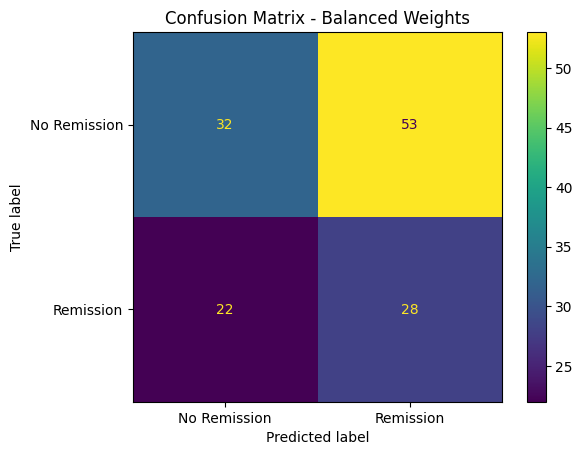


Best Weighting Schemes:
accuracy: specificity_weights
auc: sensitivity_weights
sensitivity: sensitivity_weights
specificity: specificity_weights


In [65]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_performance_weights():
    """Calculate different weighting schemes based on model performance"""


    
    # Performance metrics for each model [BN, Expert, NB]
    accuracies = [bn_accuracy, bnExpert_accuracy, nb_accuracy]
    aucs = [bn_auc,bnExpert_auc,nb_auc]
    sensitivities = [bn_sensitivity, bnExpert_sensitivity, nb_sensitivity]
    specificities = [bn_specificity, bnExpert_specificity, nb_specificity]
    
    # Different weighting schemes
    weights = {
        'accuracy_weights': [w/sum(accuracies) for w in accuracies],
        'auc_weights': [w/sum(aucs) for w in aucs],
        'sensitivity_weights': [w/sum(sensitivities) for w in sensitivities],
        'specificity_weights': [w/sum(specificities) for w in specificities],
        'balanced_weights': [
            (acc + auc + sens + spec)/4 
            for acc, auc, sens, spec in zip(accuracies, aucs, sensitivities, specificities)
        ]
    }
    
    # Normalize balanced weights
    weights['balanced_weights'] = [w/sum(weights['balanced_weights']) for w in weights['balanced_weights']]
    
    return weights

def weighted_voting(bn_probs, expert_probs, nb_probs, weights):
    """
    Combine predictions using provided weights
    """
    final_probs = (
        weights[0] * bn_probs +
        weights[1] * expert_probs +
        weights[2] * nb_probs
    )
    predictions = (final_probs >= 0.5).astype(int)
    return predictions, final_probs

# Get different weighting schemes
weights = get_performance_weights()

# Try each weighting scheme
results = {}
for weight_type, weight_values in weights.items():
    predictions, probs = weighted_voting(
        bn_predicted_probs['Remission_52w_1'],
        bnExpert_predicted_probs['Remission_52w_1'],
        nb_predicted_probs_positive,
        weight_values
    )
    
    # Calculate metrics
    acc = accuracy_score(outcome, predictions)
    auc = roc_auc_score(outcome, probs)
    conf_matrix = confusion_matrix(outcome, predictions)
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    results[weight_type] = {
        'accuracy': acc,
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'weights': weight_values
    }
    
    print(f"\n{weight_type.replace('_', ' ').title()}:")
    print(f"Weights: {[f'{w:.3f}' for w in weight_values]}")
    print(f"Accuracy: {acc:.3f}")
    print(f"AUC: {auc:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                 display_labels=['No Remission', 'Remission'])
    disp.plot()
    plt.title(f'Confusion Matrix - {weight_type.replace("_", " ").title()}')
    plt.show()

# Find best performing weighting scheme for each metric
best_weights = {
    'accuracy': max(results.items(), key=lambda x: x[1]['accuracy'])[0],
    'auc': max(results.items(), key=lambda x: x[1]['auc'])[0],
    'sensitivity': max(results.items(), key=lambda x: x[1]['sensitivity'])[0],
    'specificity': max(results.items(), key=lambda x: x[1]['specificity'])[0]
}

print("\nBest Weighting Schemes:")
for metric, weight_type in best_weights.items():
    print(f"{metric}: {weight_type}")